In [4]:
using Random, Distributions
using Plots
using AdaptiveSurveillance

In [6]:
const output_path = joinpath(dirname(pathof(AdaptiveSurveillance)), "..", "results", "tmp")
const L = 2
const p0 = [0.01, 0.02] # 0.01 * ones(L)
const β = 4e-6 * 536 * 7
const p = repeat(prevalance_sequence(p0[1], β), 1, L) # fix this
const n = 200

200

In [10]:
ν = 1 / (26) # approx 6 months until there is an outbreak
Γd = [Geometric(ν) for l = 1:L]

2-element Array{Geometric{Float64},1}:
 Geometric{Float64}(p=0.038461538461538464)
 Geometric{Float64}(p=0.038461538461538464)

In [7]:
const α = 10000 # the higher, the less false positives

10000

In [ ]:
# Debug
Γ = [0, typemax(Int64)]
beta_parameters = ones(L, 2)
recent_beta_parameters = ones(L, 2)
t, la, false_alarm, delay, test_data, locations_visited, ntimes_visisted, 
    last_time_visited, z, w, prevalance_history = replication(L, Γ, p0, p, n,
    astat_isotonic, α, tpolicy_evsi, tstate_evsi(),
    rng1 = MersenneTwister(1), rng2 = MersenneTwister(2), maxiters = 1000);

┌ Error: Failed to revise /Users/mfairley/Projects/AdaptiveSurveillance/src/semiparametric.jl
│   exception = Revise.ReviseEvalException("/Users/mfairley/Projects/AdaptiveSurveillance/src/semiparametric.jl:142", ErrorException("invalid redefinition of constant tstate_evsi"), Any[(top-level scope at semiparametric.jl:142, 1)])
└ @ Revise /Users/mfairley/.julia/packages/Revise/fwStr/src/packagedef.jl:693
┌ Warning: The running code does not match the saved version for the following files:
│ 
│   /Users/mfairley/Projects/AdaptiveSurveillance/src/semiparametric.jl
│ 
│ If the error was due to evaluation order, it can sometimes be resolved by calling `Revise.retry()`.
│ Use Revise.errors() to report errors again. Only the first error in each file is shown.
│ Your prompt color may be yellow until the errors are resolved.
└ @ Revise /Users/mfairley/.julia/packages/Revise/fwStr/src/packagedef.jl:791


LoadError: MethodError: no method matching tstate_evsi()

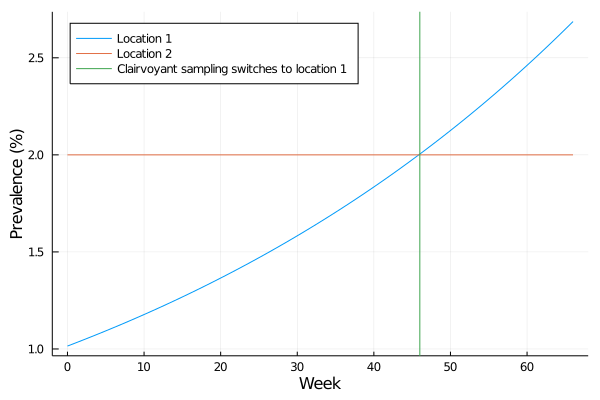

In [13]:
plot(0:(t-1), prevalance_history[1:t, :] * 100, label = ["Location 1" "Location 2"],
    xlabel = "Week", ylabel = "Prevalence (%)", legend = :topleft)
vline!([46], label = "Clairvoyant sampling switches to location 1")
#savefig(joinpath(output_path, "prevalance_seq.pdf"))

In [ ]:
replace!(test_data, -1=>NaN)
bar(1:(t-1), test_data[1:(t-1), :], xlabel = "Week", ylabel = "Positive Count", labels = ["Location 1" "Location 2" "l3"])
vline!([20], label = "Outbreak Start in Location 1")
savefig(joinpath(output_path, "positive_counts.pdf"))

In [ ]:
plot(2:(t-1), hcat(z[3:t, :], repeat([log(α)], t-2)), xlabel = "Week", ylabel = "Alarm Statistic", 
    label = [permutedims(["Location $l" for l = 1:L])... "Threshold"], legend=:topleft)
vline!([20], label = "Outbreak Start in Location 1")
savefig(joinpath(output_path, "alarm_stat.pdf"))

In [ ]:
# Alarm time distribution
atd_T = 200
atd_0 = alarm_time_distribution(Int(1e6), L, zeros(Int64, L), p0, p, n, astat_isotonic, α, 
    tpolicy_constant, tstate_const(2), maxiters=atd_T);
atd_0 = cumsum(atd_0) ./ sum(atd_0);

In [ ]:
atd_1 = alarm_time_distribution(Int(1e6), L, ones(Int64, L) * typemax(Int64), p0, p, n, astat_isotonic, α, 
    tpolicy_constant, tstate_const(2), maxiters=atd_T);
atd_1 = cumsum(atd_1) ./ sum(atd_1);

In [ ]:
plot(1:atd_T, hcat(atd_0[1:atd_T], atd_1[1:atd_T]), label = ["Outbreak starts in week 0" "Outbreak never starts"], legend=:topleft,
    xlim=(0, 100), xlabel = "Week", ylabel = "Cumulative Probability of Alarm")

In [ ]:
savefig(joinpath(output_path, "alarm_time_distr.pdf"))

In [ ]:
# Probability of successful detection
T_end = 21

In [ ]:
sp2s, hw2s = probability_successfull_detection_l(Int(1e4), T_end, 47, 1, L, p0, p, n, astat_isotonic, α,
    tpolicy_constant, tstate_const(1));
sp3s, hw3s = probability_successfull_detection_l(Int(1e4), T_end, 75, 1, L, p0, p, n, astat_isotonic, α,
    tpolicy_constant, tstate_const(1));

In [ ]:
plot(1:T_end, hcat(sp2s, sp3s), label = ["2x" "3x"], xlabel = "Outbreak Start Time", ylabel = "PSD", ylim=(0, 1.0))

In [ ]:
sp2r, hw2r = probability_successfull_detection_l(Int(1e4), T_end, 47, 1, L, p0, p, n, astat_isotonic, α,
    tpolicy_random, nothing);
sp3r, hw3r = probability_successfull_detection_l(Int(1e4), T_end, 75, 1, L, p0, p, n, astat_isotonic, α,
    tpolicy_random, nothing);

In [ ]:
plot(1:T_end, hcat(sp2r, sp3r), label = ["2x" "3x"], xlabel = "Outbreak Start Time", ylabel = "PSD", ylim=(0, 1.0))

In [ ]:
# thompson sampling
sp2ts, hw2ts = probability_successfull_detection_l(Int(1e4), T_end, 47, 1, L, p0, p, n, astat_isotonic, α,
    tpolicy_thompson, tstate_thompson(ones(L, 2)));
sp3ts, hw3ts = probability_successfull_detection_l(Int(1e4), T_end, 75, 1, L, p0, p, n, astat_isotonic, α,
    tpolicy_thompson, tstate_thompson(ones(L, 2)));

In [ ]:
plot(1:T_end, hcat(sp2ts, sp3ts), label = ["2x" "3x"], xlabel = "Outbreak Start Time", ylabel = "PSD", ylim=(0, 1.0))

In [ ]:
sp2vi, hw2vi = probability_successfull_detection_l(Int(1e4), T_end, 47, 1, L, p0, p, n, astat_isotonic, α,
    tpolicy_evsi, tstate_evsi(Γd, ones(L, 2), ones(L, 2)));
sp3vi, hw3vi = probability_successfull_detection_l(Int(1e4), T_end, 75, 1, L, p0, p, n, astat_isotonic, α,
    tpolicy_evsi, tstate_evsi(Γd, ones(L, 2), ones(L, 2)));

In [ ]:
plot(1:T_end, hcat(sp2vi, sp3vi), label = ["2x" "3x"], xlabel = "Outbreak Start Time", ylabel = "PSD", ylim=(0, 1.0))

In [ ]:
plot(hcat(0:10, 5:15); ribbon = [LinRange(0, 2, 11) LinRange(0, 0, 11)])


In [ ]:
plot(1:T_end, sp2s, ribbon = hw2s, ylim=(0, 1), label = "Upper Bound", xlabel = "Outbreak Start Week",
    ylabel = "Probability of Successful Detection", svg = true)
savefig(joinpath(output_path, "upper_bound_psd.pdf"))

In [ ]:
plot(1:T_end, hcat(sp2s, sp2r), ribbon = hcat(hw2s, hw2r), ylim=(0, 1), label = ["Upper Bound" "Uniform Random"], xlabel = "Outbreak Start Week",
    ylabel = "Probability of Successful Detection", svg = true)
savefig(joinpath(output_path, "random_psd.pdf"))

In [ ]:
plot(1:T_end, hcat(sp2s, sp2r, sp2ts), ribbon = hcat(hw2s, hw2r, hw2ts), ylim=(0, 1), 
    label = ["Upper Bound" "Uniform Random" "Thompson Sampling"], xlabel = "Outbreak Start Week",
    ylabel = "Probability of Successful Detection", svg = true)
savefig(joinpath(output_path, "thompson_psd.pdf"))

In [ ]:
plot(1:T_end, hcat(sp2s, sp2r, sp2ts, sp2vi), ribbon = hcat(hw2s, hw2r, hw2ts, hw2vi), ylim=(0, 1), 
    label = ["Upper Bound" "Uniform Random" "Thompson Sampling" "Value of Information"], xlabel = "Outbreak Start Week",
    ylabel = "Probability of Successful Detection", svg = true)
savefig(joinpath(output_path, "voi_psd.pdf"))

In [ ]:
plot(1:T_end, hcat(sp2s, sp2r, sp2ts, sp2vi), label = ["UB" "Random" "TS" "VoI"], xlabel = "Outbreak Start Time", ylabel = "PSD", ylim=(0, 1.0))

In [ ]:
plot(1:T_end, hcat(sp3s, sp3r, sp3ts, sp3vi), label = ["UB" "Random" "TS" "VoI"], xlabel = "Outbreak Start Time", ylabel = "PSD", ylim=(0, 1.0))